In [1]:
%matplotlib notebook

In [128]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from tqdm import tqdm


In [135]:
class leaf():
    def __init__(self, bbox=np.array([[-1, 1],[-1, 1]]), depth=1):
        # if the leaf has a particle ... 
        self.mass = None
        self.com = None
        # center position of quadrant 
        self.center = np.array([bbox[0].sum() / 2, bbox[1].sum() / 2])
        # length of bounding box, same for x- and y- axes 
        self.length = bbox[0, 1] - bbox[0, 0]
        self.depth = depth 

        
class QuadTree():
    # tree constructor .. 
    def __init__(self, oleaf=leaf()):
        # inherit from the original leaf node ... 
        self.center = oleaf.center
        self.length = oleaf.length
        self.depth = oleaf.depth
        self.mass = oleaf.mass 
        self.com = oleaf.com 
        
        # initialize leaf nodes ... 
        self.ll = leaf(depth = self.depth + 1, bbox=np.array([[oleaf.center[0] - oleaf.length / 2, oleaf.center[0]], 
                                 [oleaf.center[1] - oleaf.length / 2, oleaf.center[1]]]),)
        self.ul = leaf(depth = self.depth + 1, bbox=np.array([[oleaf.center[0] - oleaf.length / 2, oleaf.center[0]], 
                                 [oleaf.center[1], oleaf.center[1] + oleaf.length / 2]]))
        self.ur = leaf(depth = self.depth + 1, bbox=np.array([[oleaf.center[0], oleaf.center[0] + oleaf.length / 2], 
                                 [oleaf.center[1], oleaf.center[1] + oleaf.length / 2]]))
        self.lr = leaf(depth = self.depth + 1, bbox=np.array([[oleaf.center[0], oleaf.center[0] + oleaf.length / 2], 
                                 [oleaf.center[1] - oleaf.length / 2, oleaf.center[1]]]))
                

def plotter(node, c, alpha=0.1):
    plt.plot(
    [node.center[0] + node.length / 2, node.center[0] - node.length / 2, node.center[0] - node.length / 2, 
     node.center[0] + node.length / 2, node.center[0] + node.length / 2],
    [node.center[1] + node.length / 2, node.center[1] + node.length / 2, node.center[1] - node.length / 2, 
     node.center[1] - node.length / 2, node.center[1] + node.length / 2], 
    alpha=alpha, c=c)
    
    return 0 


def drawTree(node): 
    if isinstance(node, leaf):
        if node.com is not None: 
            plotter(node, 'c', 0.2)
            return 0 
    else: 
        plotter(node, 'white', 0.05)
        _ = [drawTree(n) for n in [node.ul, node.ur, node.ll, node.lr]]
        
        
def quadAssign(p, node): 
    theta = np.arctan2(p[1] - node.center[1], p[0] - node.center[0]) * 180 / np.pi
    if theta < 90 and theta > 0: 
        node.ur = assignParticle(p, node.ur)
    elif theta < 180 and theta >= 90: 
        node.ul = assignParticle(p, node.ul)
    elif theta < 0 and theta >= -90:
        node.lr = assignParticle(p, node.lr)
    else: # theta < 360 and theta >= 270 
        node.ll = assignParticle(p, node.ll)
    return node
    
        
def assignParticle(p, node):
    # if a leaf has no particle, assign particle to leaf 
    if isinstance(node, leaf) and node.com is None:
        node.com = p
        node.mass = 1
    # if a leaf has a particle, make it a tree and re-assign particles
    elif isinstance(node, leaf) and node.com is not None: 
        p_old = node.com 
        node = QuadTree(node)
        node = assignParticle(p, node)  
        node = assignParticle(p_old, node)
        node.com = (p_old + p) / 2
    # if tree, find out where in the tree the particle should live 
    else: 
        node = quadAssign(p, node)
        node.com = (node.com * node.mass + p) / node.mass + 1
        node.mass = node.mass + 1 
        
    return node


<IPython.core.display.Javascript object>


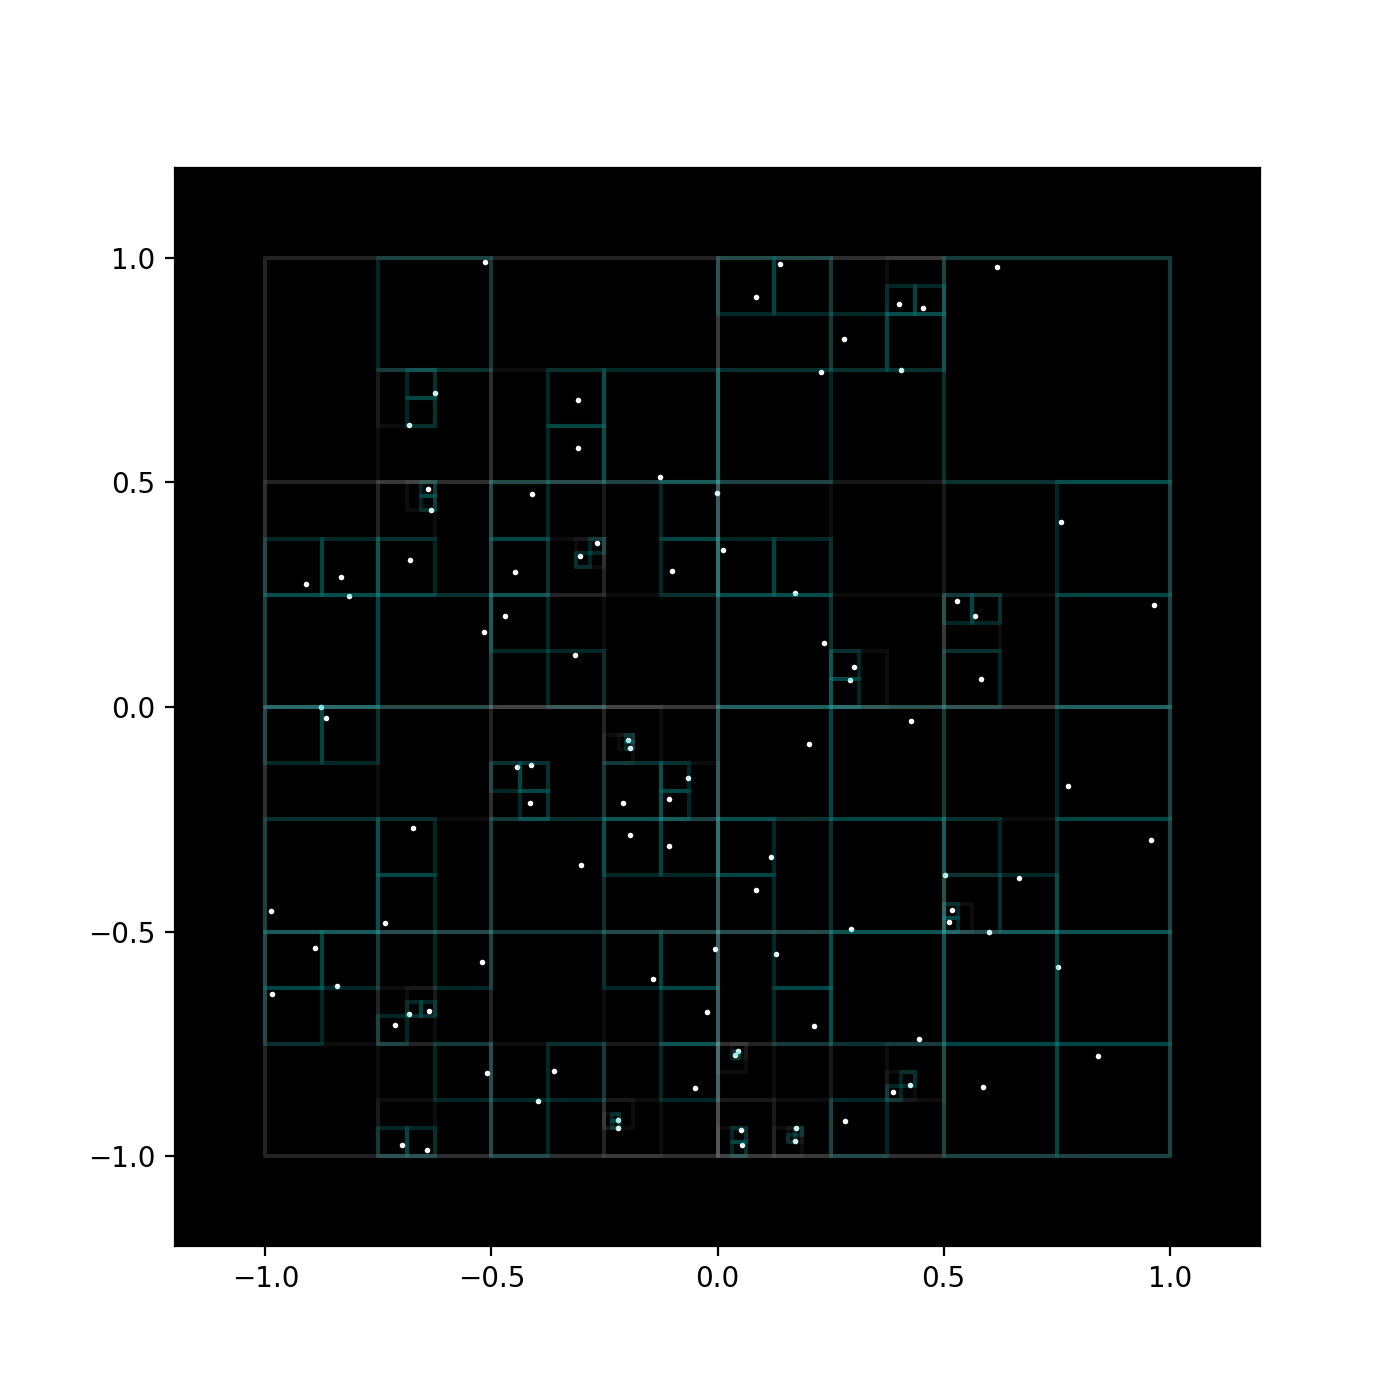

(-1.2, 1.2)

In [136]:
# random particles originally from (0, 1), scaled to (0, 2), shifted to (-1, 1)
particles = np.random.random((100, 4))  * 2 - 1
particles[:, 2] = 0.1
particles[:, 3] = 0 

# we start with a simple leaf (root) 
root = leaf()
# which we then can immediately turn into a tree 

for p in particles: 
    root = assignParticle(p[0:2], root)
    
fig, ax = plt.subplots(figsize=(7, 7), dpi=100)
ax.set_facecolor("black")

drawTree(root)
plt.scatter(particles[:, 0], particles[:, 1], s = 1, c='white')

plt.xlim(-1.2, 1.2)
plt.ylim(-1.2, 1.2)


In [138]:
# function holding our quantities we want to get d/dt for 
# so we can use them in RK function 
def f(r, t, node): 
    x = r[:, 0]
    y = r[:, 1]
    xdot = r[:, 2]
    ydot = r[:, 3]
    
    # f_arr = []
    # for p in r: 
    #    f_arr.append(calc_f(p, node))
    # f_arr = np.array(f_arr)
    
    a = xdot
    b = ydot
    da = np.ones(len(x)) * 0 # f_arr[:, 0]
    db = np.ones(len(x)) * 0 # f[:, 0]

    return np.array([a, b, da, db], float).T


def RK4(r, t_start=0, t_end=10, N=1e4):
    h = 100 # (t_end - t_start)/N

    tpoints = np.arange(t_start, t_end, h)
    xpoints = []
    trees = []

    for t in tqdm(tpoints):
        # have to .copy() because we are updating the same array and that causes memory issues 
        xpoints.append(r.copy())
        
        # we start with a simple leaf (root) 
        root = leaf()
        # which we then can immediately turn into a tree 
        for p in r: 
            root = assignParticle(p[0:2], root)
        trees.append(root)
        
        k1 = h*f(r, t, root)
        k2 = h*f(r + 0.5*k1, t + 0.5*h, root)
        k3 = h*f(r + 0.5*k2, t + 0.5*h, root)
        k4 = h*f(r + k3, t + h, root)
        
        r += (k1 + 2*k2 + 2*k3 + k4) / 6
        
        # boundary condition fixing 
        r[r[:, 0] > 1, 0] = r[r[:, 0] > 1, 0] - 2
        r[r[:, 0] < -1, 0] = r[r[:, 0] < -1, 0] + 2
        r[r[:, 1] > 1, 1] = r[r[:, 1] > 1, 1] - 2
        r[r[:, 1] < -1, 1] = r[r[:, 1] < -1, 1] + 2
        
    return tpoints, np.array(xpoints), trees

In [139]:
tpoints, particles_list, trees = RK4(particles)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 107.37it/s]


<IPython.core.display.Javascript object>


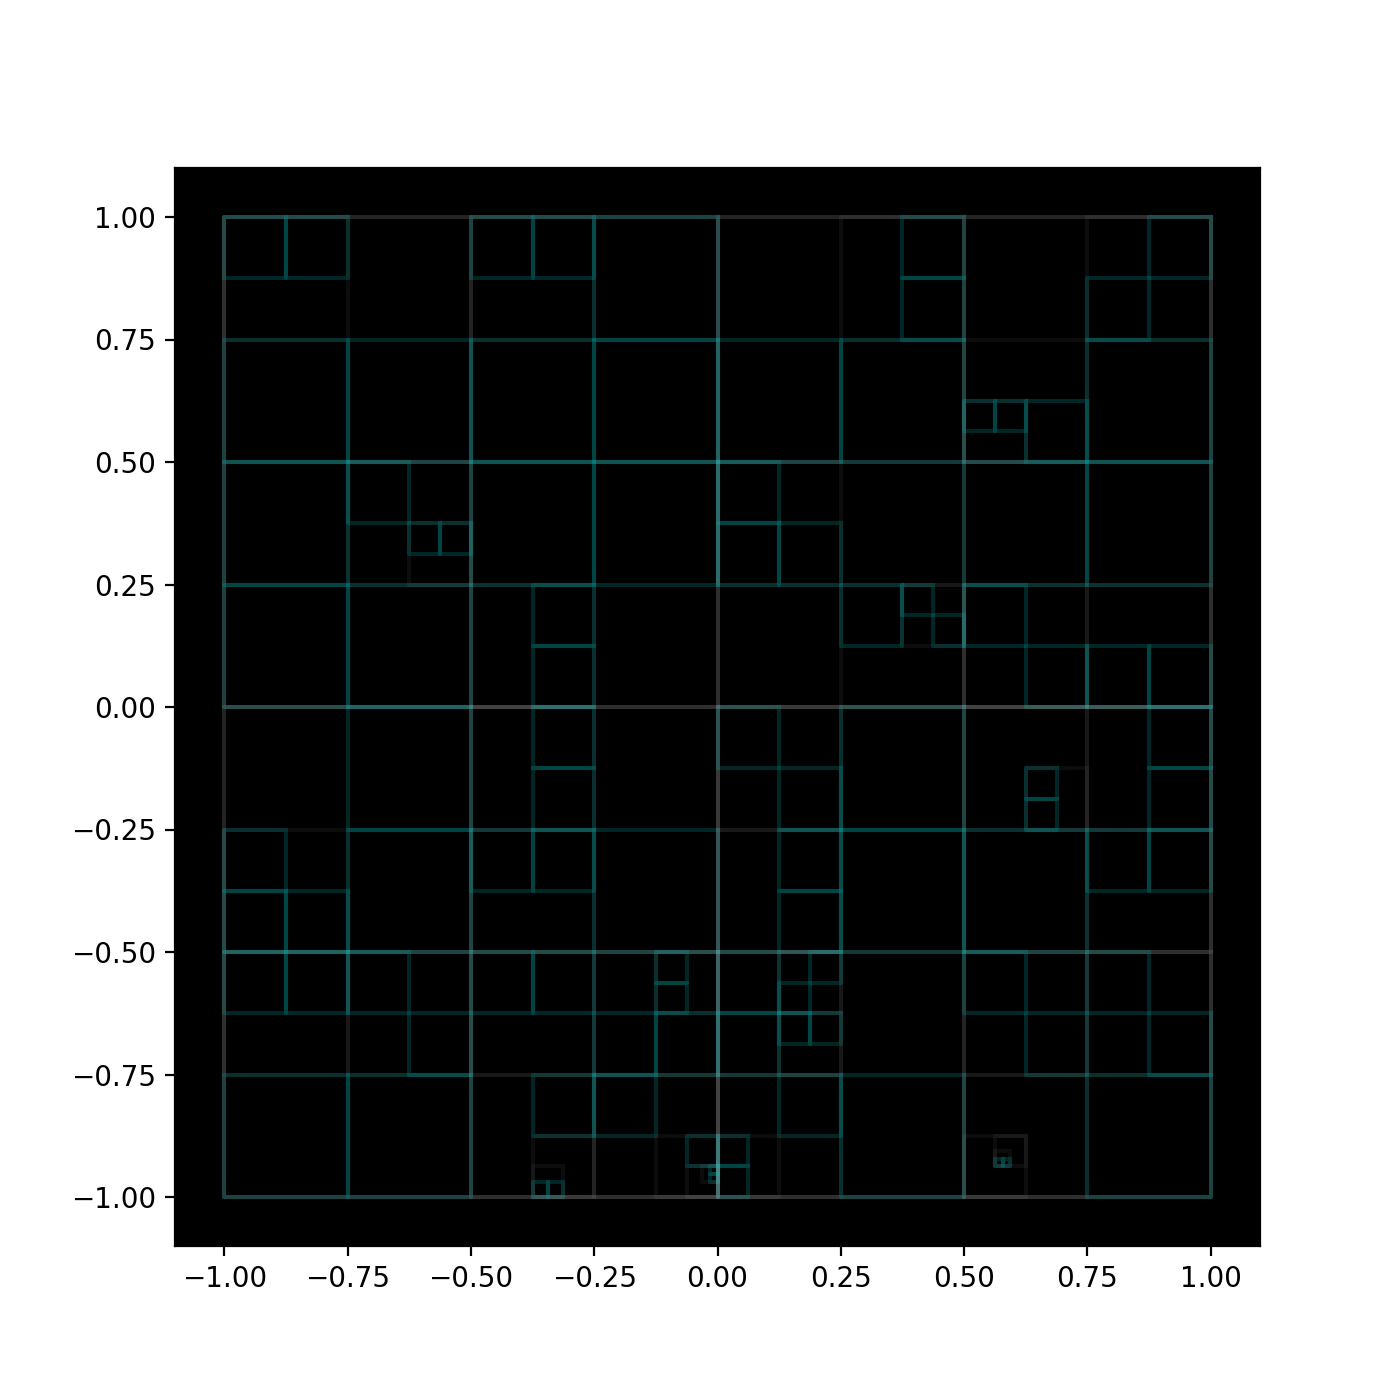

In [134]:
fig, ax = plt.subplots(figsize=(7, 7), dpi=100)
ax.set_facecolor("black")

drawTree(trees[0])

In [ ]:
theta = 0.1
softening = 0.01

In [ ]:
force_arr = []
for particle in particles: 
    force = np.zeros(2)
    node_list = [root]
    for node in node_list: 
        if isinstance(node, QuadTree) and node.length / sum((node.com - particle)**2)**(0.5) < theta: 
            th = np.arctan2(particle[1] - node.com[1], particle[0] - node.com[0]) * 180 / np.pi
            force += node.mass / (node.com - p + softening)**2 * [np.cos(th), np.sin(th)]
        elif isinstance(node, QuadTree) and node.length / sum((node.com - particle)**2)**(0.5) > theta: 
            for ch in [node.ll, node.ur, node.lr, node.ul]:
                if isinstance(ch, QuadTree): 
                    node_list.append(ch)
                if isinstance(ch, leaf) and ch.com is not None:
                    if sum((ch.com - particle)**2)**0.5 > 1e-10:
                        th = np.arctan2(particle[1] - node.com[1], particle[0] - node.com[0]) * 180 / np.pi
                        force += ch.mass / (ch.com - particle + softening)**2 * [np.cos(th), np.sin(th)]
    force_arr.append(force)
force_arr = np.array(force_arr)

<IPython.core.display.Javascript object>


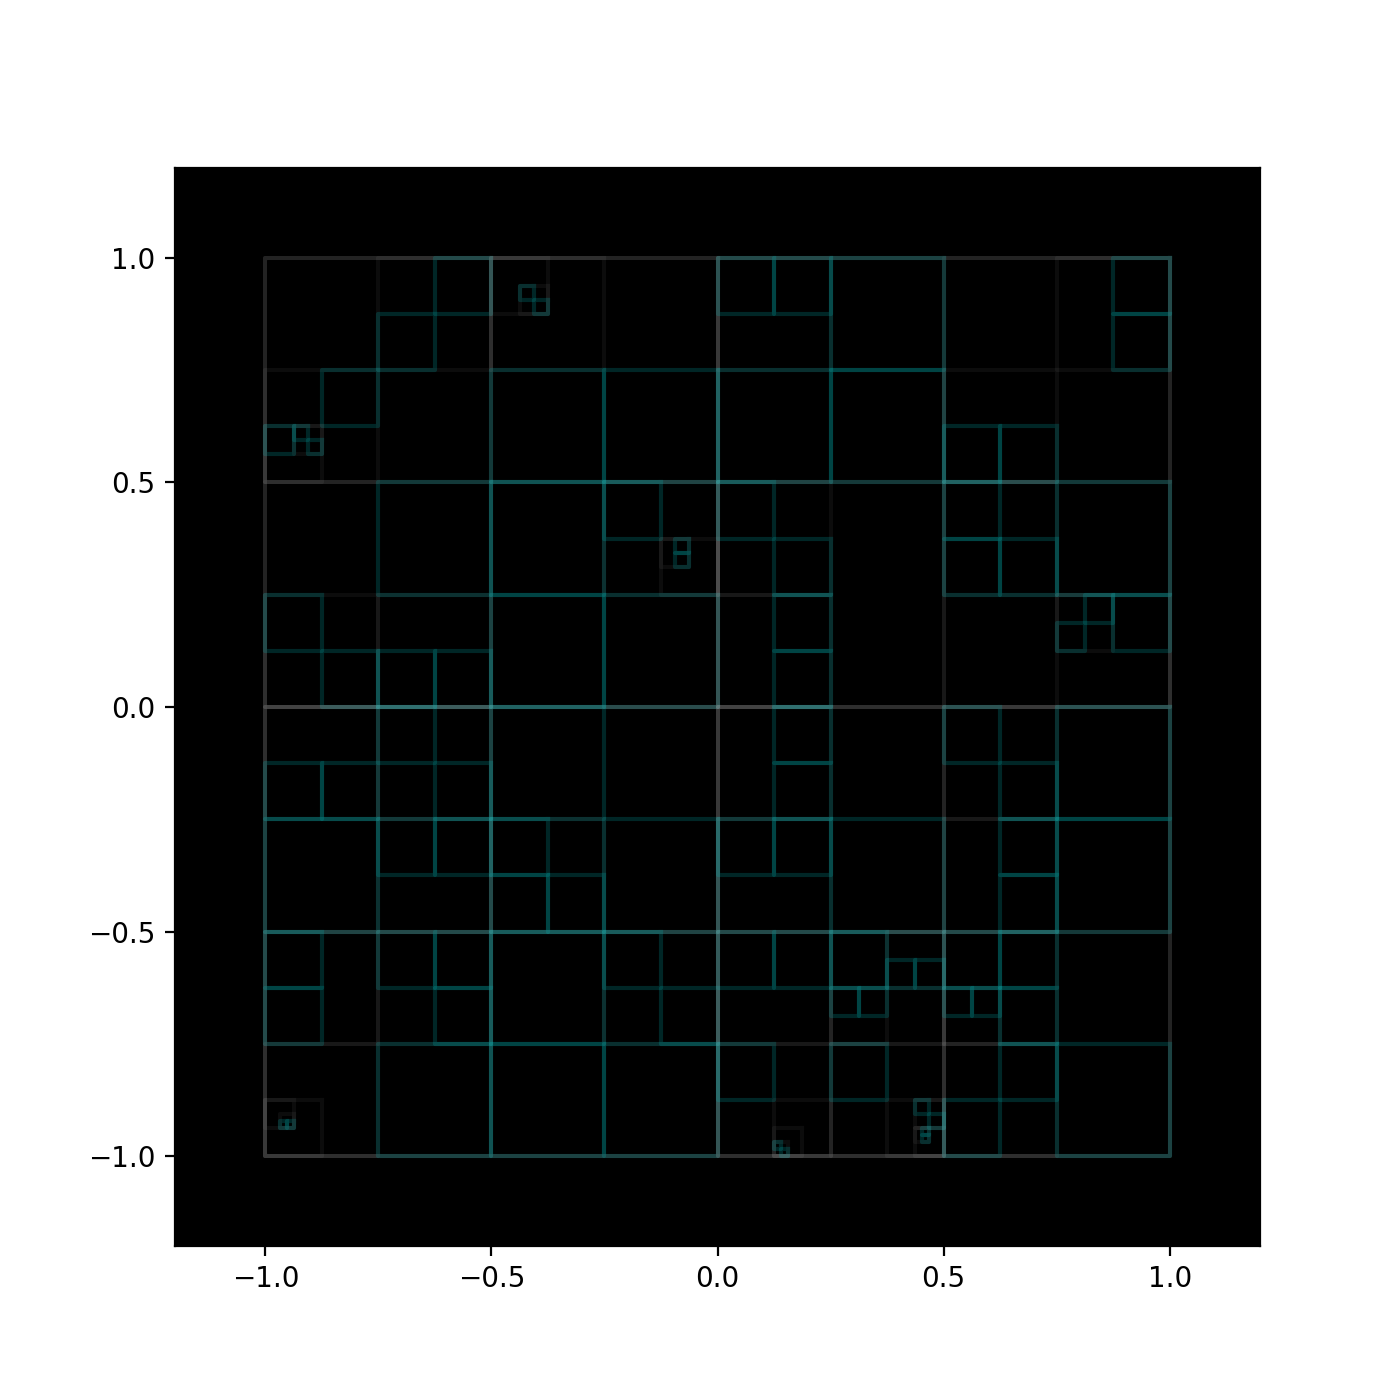

(-1.2, 1.2)

In [36]:
fig, ax = plt.subplots(figsize=(7, 7), dpi=100)
ax.set_facecolor("black")
 
drawTree(root)

plt.xlim(-1.2, 1.2)
plt.ylim(-1.2, 1.2)

<IPython.core.display.Javascript object>


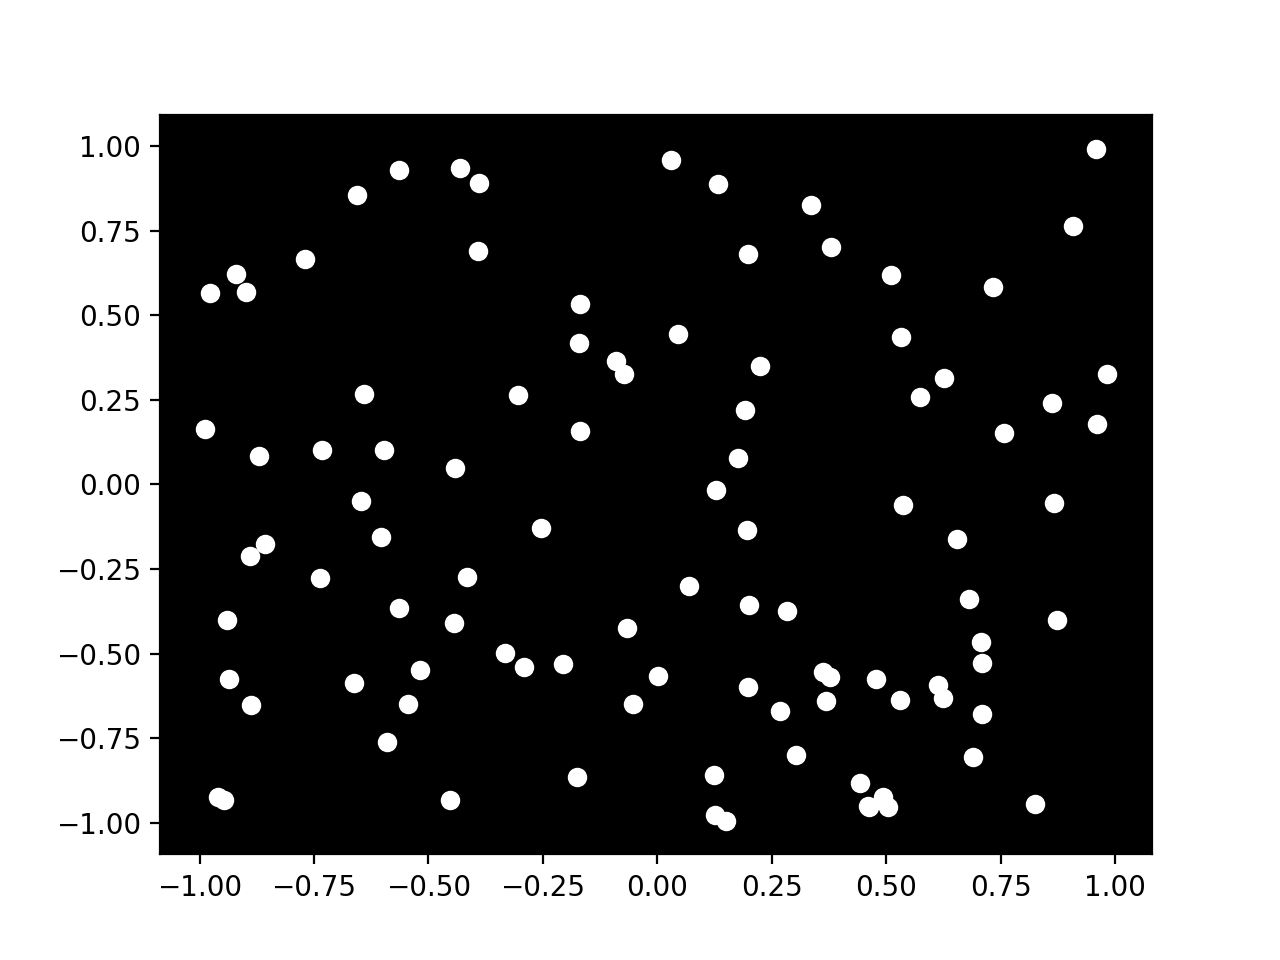

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [70]:
re

In [59]:
np.random.random((10, 10, 2))[0]

array([[0.10764074, 0.6209019 ],
       [0.99004853, 0.54917079],
       [0.60774166, 0.18410166],
       [0.98639431, 0.0547765 ],
       [0.82931401, 0.65119042],
       [0.93659697, 0.57450439],
       [0.25165229, 0.64842037],
       [0.90838035, 0.40396158],
       [0.63710086, 0.80568944],
       [0.09165222, 0.8306528 ]])